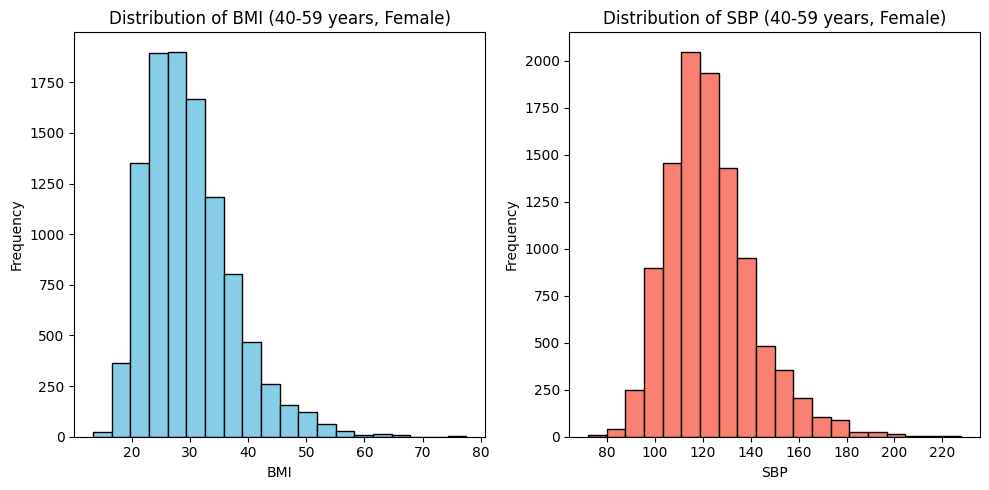

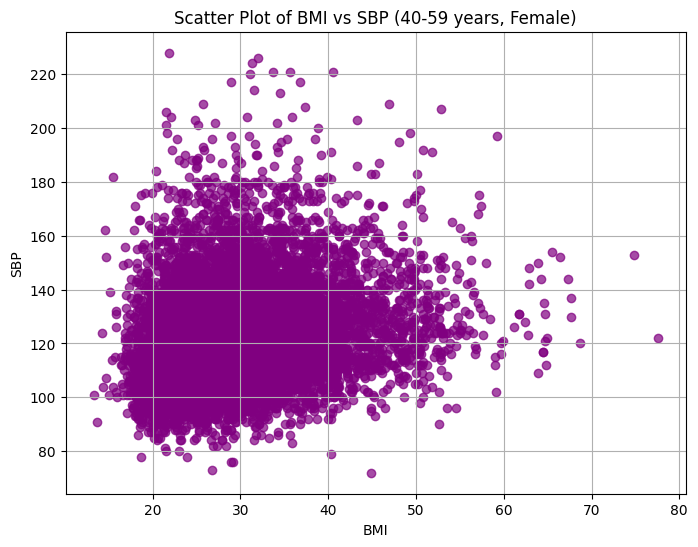

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import multivariate_normal, invwishart, dirichlet
from tqdm import tqdm
from Samplers.gibbs_sampler import *
import matplotlib.patches as patches
import matplotlib.pyplot as plt
import numpy as np

filtered_data = data[(data['sex'] == 2) & (data['age'] >= 40) & (data['age'] < 60)]
filtered_data = data[(data['sex'] == 2) & (data['age'] >= 40) & (data['age'] < 60)]
cleaned_data = filtered_data[
    (filtered_data['bmi'] >= 10) & (filtered_data['bmi'] <= 80) &
    (filtered_data['sbp'] >= 70) & (filtered_data['sbp'] <= 270)
]
bmi_sbp_data = cleaned_data[['bmi', 'sbp']]

# Plot BMI and SBP distributions
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.hist(bmi_sbp_data['bmi'], bins=20, color='skyblue', edgecolor='black')
plt.title('Distribution of BMI (40-59 years, Female)')
plt.xlabel('BMI')
plt.ylabel('Frequency')

plt.subplot(1, 2, 2)
plt.hist(bmi_sbp_data['sbp'], bins=20, color='salmon', edgecolor='black')
plt.title('Distribution of SBP (40-59 years, Female)')
plt.xlabel('SBP')
plt.ylabel('Frequency')

plt.tight_layout()
plt.show()

# Scatter plot between BMI and SBP
plt.figure(figsize=(8, 6))
plt.scatter(bmi_sbp_data['bmi'], bmi_sbp_data['sbp'], alpha=0.7, color='purple')
plt.title('Scatter Plot of BMI vs SBP (40-59 years, Female)')
plt.xlabel('BMI')
plt.ylabel('SBP')
plt.grid()
plt.show()

# Display filtered data summary
bmi_sbp_summary = bmi_sbp_data.describe()
bmi_sbp_summary

def h1(mu):
    h = np.min([np.linalg.norm(mu[i] - mu[j]) for i in range(len(mu)) for j in range(len(mu)) if i != j])
    return h

def h2(mu):
    """
    Returns 1 if unique, 0 otherwise.
    """
    # Define BMI and SBP interval bounds
    bmi_bounds = np.array([18, 25, 30, np.inf])
    sbp_bounds = np.array([120, 140, np.inf])
    
    # Extract BMI and SBP values from mu
    bmi = mu[:, 0]
    sbp = mu[:, 1]
    
    # Use np.digitize to find interval indices for BMI and SBP
    bmi_blocks = np.digitize(bmi, bins=bmi_bounds)
    sbp_blocks = np.digitize(sbp, bins=sbp_bounds)
    
    # Combine BMI and SBP block indices into tuples
    blocks = set(zip(bmi_blocks, sbp_blocks))
    
    # If all blocks are unique, return 1; otherwise, return 0
    return 1 if len(blocks) == len(mu) else 0



In [23]:
def bayesian_repulsive(X, K, num_iterations, h):
    """
    Optimized Gibbs Sampler with Bayesian Repulsion.
    """
    N, p = X.shape  # Number of data points (N) and dimensions (p)

    # --- Initialization ---
    z = np.random.randint(0, K, size=N)  # Random initial cluster assignments
    pi = dirichlet.rvs(np.ones(K) * 2, size=1).flatten()  # Randomized mixing proportions
    mu = np.random.multivariate_normal(np.mean(X, axis=0), np.cov(X.T), size=K)  # Randomized means
    Sigma = np.array([np.cov(X.T) + 1e-6 * np.eye(p) for _ in range(K)])  # Positive-definite covariances

    # Hyperparameters for priors
    alpha = np.ones(K) * 5  # Dirichlet prior for mixing proportions
    mu0 = np.mean(X, axis=0)  # Prior for means
    lambda0 = 1.0  # Precision for means
    nu0 = p + 2  # Degrees of freedom for Inverse-Wishart prior
    Psi0 = np.cov(X.T) * 2  # Scale matrix for Inverse-Wishart prior

    samples = []  # List to store the sampled parameters

    # --- Gibbs Sampling Loop ---
    for iteration in tqdm(range(num_iterations), desc="Sampling"):
        # Step 1: Sample z_i (Cluster Assignments)
        log_posterior = np.log(np.maximum(pi, 1e-10))[np.newaxis,:] + np.array(
            [multivariate_normal.logpdf(X, mean=mu[k], cov=Sigma[k]) for k in range(K)]
        ).T
        posterior_probs = np.exp(log_posterior - log_posterior.max(axis=1, keepdims=True))  # Stability
        posterior_probs /= posterior_probs.sum(axis=1, keepdims=True)
        z = np.array([np.random.choice(K, p=p) for p in posterior_probs])

        # Step 2: Update mu_k (Cluster Means) with M-H
        for k in range(K):
            X_k = X[z == k]
            n_k = len(X_k)
            if n_k > 0:
                mean_k = np.mean(X_k, axis=0)
                mu_n = (lambda0 * mu0 + n_k * mean_k) / (lambda0 + n_k)
                lambda_n = lambda0 + n_k
                Sigma_k = Sigma[k] / lambda_n

                # Propose new mu_k
                mu_proposed = np.random.multivariate_normal(mu_n, Sigma_k)
                current_h = h(mu)
                proposed_mu = mu.copy()
                proposed_mu[k] = mu_proposed
                proposed_h = h(proposed_mu)

                log_acceptance_ratio = (
                    multivariate_normal.logpdf(mu_proposed, mean=mu_n, cov=Sigma_k)
                    - multivariate_normal.logpdf(mu[k], mean=mu_n, cov=Sigma_k)
                    + np.log(np.maximum(proposed_h, 1e-10))
                    - np.log(np.maximum(current_h, 1e-10))
                )
                if np.log(np.random.rand()) < log_acceptance_ratio:
                    mu[k] = mu_proposed  # Accept

        # Step 3: Update Sigma_k (Cluster Covariances)
        for k in range(K):
            X_k = X[z == k]
            n_k = len(X_k)
            if n_k > 0:
                S_k = np.cov(X_k.T, bias=True) * n_k
                nu_n = nu0 + n_k
                Psi_n = Psi0 + S_k
                Sigma[k] = invwishart.rvs(df=nu_n, scale=Psi_n)
            else:
                Sigma[k] = invwishart.rvs(df=nu0, scale=Psi0)

        # Step 4: Update pi (Mixing Proportions)
        counts = np.bincount(z, minlength=K)  # Count points in each cluster
        pi = dirichlet.rvs(alpha + counts)[0]  # Sample from the Dirichlet distribution

        # Store the current samples
        samples.append((pi.copy(), mu.copy(), Sigma.copy(), z.copy()))

    # Burn-in period
    burn_in = 100
    samples = samples[burn_in:]

    return samples

Running Gibbs Sampler for Run 1


Sampling: 100%|██████████| 5000/5000 [09:59<00:00,  8.35it/s]


Running Gibbs Sampler for Run 2


Sampling: 100%|██████████| 5000/5000 [09:53<00:00,  8.43it/s]


Running Gibbs Sampler for Run 3


Sampling: 100%|██████████| 5000/5000 [09:59<00:00,  8.34it/s]


Running Gibbs Sampler for Run 4


Sampling: 100%|██████████| 5000/5000 [10:01<00:00,  8.32it/s]


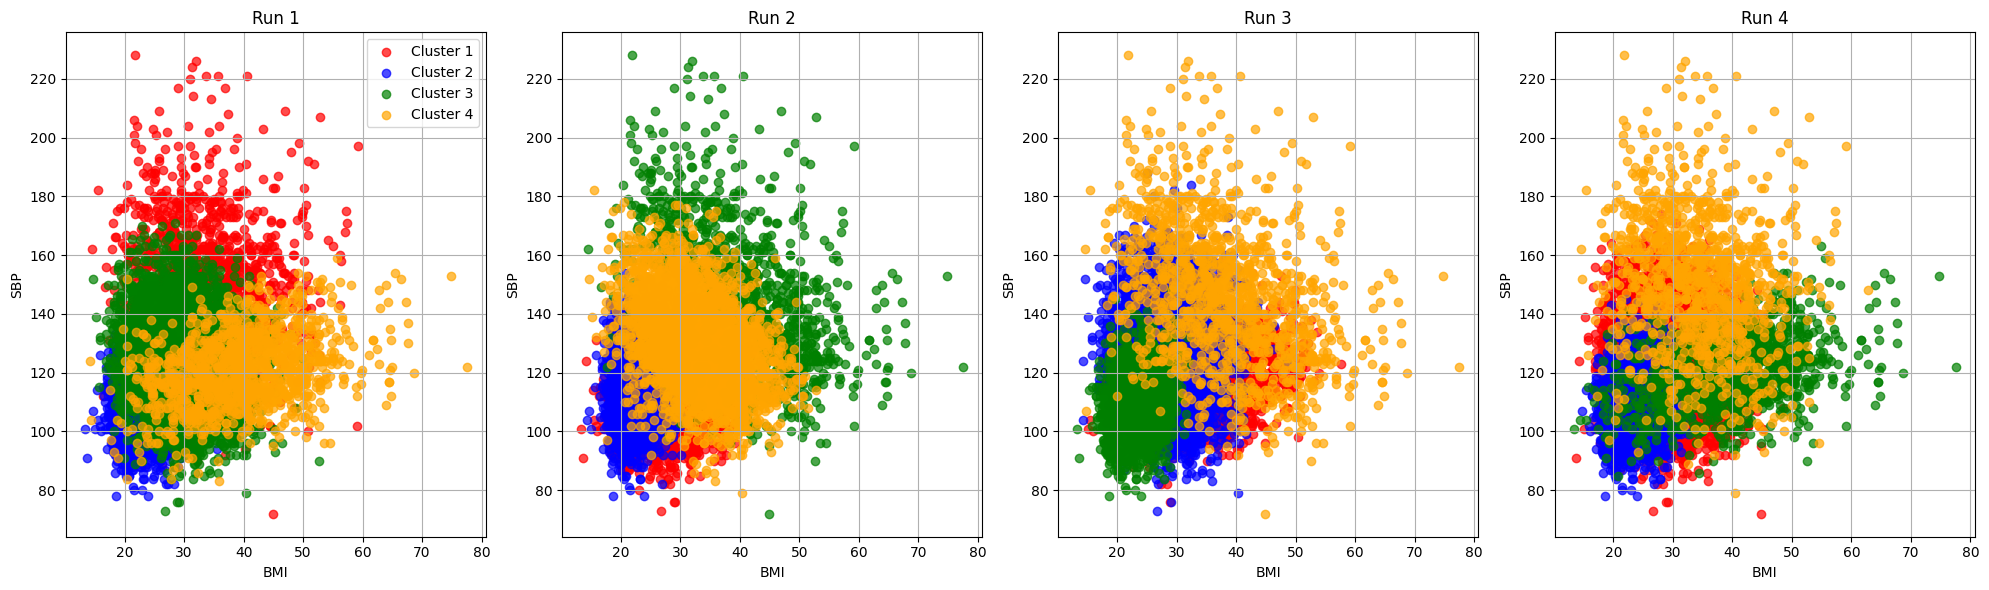

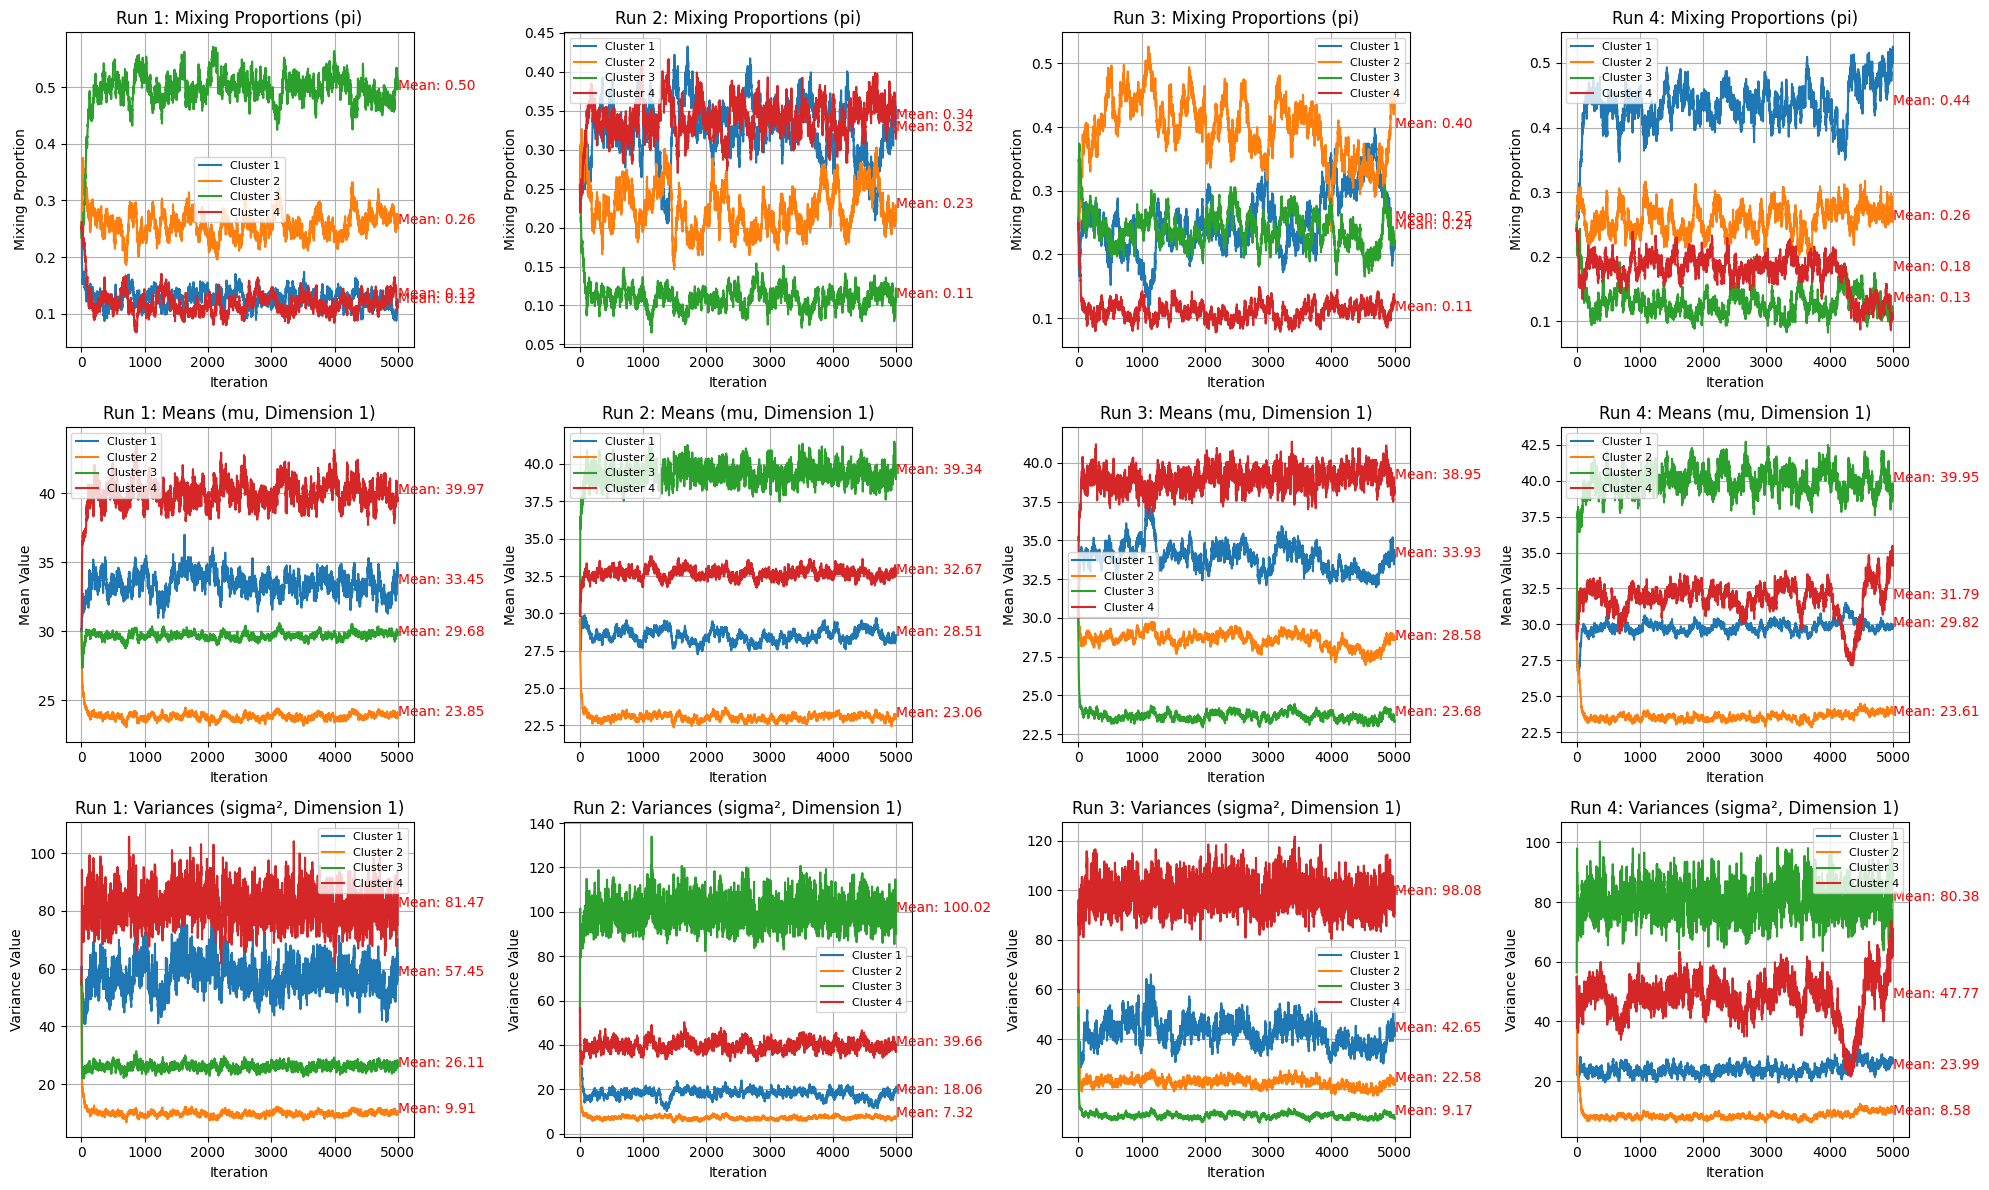

In [29]:
# Parameters
num_runs = 4
num_iterations = 5000
K = 4  # Number of clusters
X = bmi_sbp_data[['bmi', 'sbp']].to_numpy()

# Store all iterations for each run
all_run_samples = []

for run in range(num_runs):
    print(f"Running Gibbs Sampler for Run {run + 1}")
    run_samples = gibbs_sampler_gmm_multivariate(X, K, num_iterations)
    all_run_samples.append(run_samples)  # Store all iterations for the current run

# Plot results for the last iteration of each run
colors = ['red', 'blue', 'green', 'orange', 'purple', 'brown', 'cyan', 'magenta']
fig, axes = plt.subplots(1, num_runs, figsize=(20, 6))

for run, ax in enumerate(axes):
    last_sample = all_run_samples[run][-1]  # Get the last iteration for the current run
    _, _, _, z = last_sample  # Extract z (cluster assignments)
    for k in range(K):
        ax.scatter(
            X[np.array(z) == k, 0],
            X[np.array(z) == k, 1],
            alpha=0.7,
            color=colors[k],
            label=f"Cluster {k+1}" if run == 0 else None,  # Only label in the first plot
        )
    ax.set_title(f"Run {run + 1}")
    ax.set_xlabel("BMI")
    ax.set_ylabel("SBP")
    ax.grid()

axes[0].legend(loc="upper right")
plt.tight_layout()
plt.show()

# --- Trace Plots for Multiple Runs ---
fig, axes = plt.subplots(3, num_runs, figsize=(20, 12))  # 3 rows (pi, mu, sigma²), 5 columns (runs)

# Plot for each run
for run in range(num_runs):
    run_samples = all_run_samples[run]
    pi_samples = np.array([s[0] for s in run_samples])  # Mixing proportions
    mu_samples = np.array([s[1] for s in run_samples])  # Means
    sigma_samples = np.array([s[2] for s in run_samples])  # Covariances

    # --- First Row: Trace Plots for Mixing Proportions (pi) ---
    for k in range(K):
        axes[0, run].plot(pi_samples[:, k], label=f'Cluster {k + 1}')
        axes[0, run].text(num_iterations, np.mean(pi_samples[:, k]), f"Mean: {np.mean(pi_samples[:, k]):.2f}", color='red')
    axes[0, run].set_title(f"Run {run + 1}: Mixing Proportions (pi)")
    axes[0, run].set_xlabel("Iteration")
    axes[0, run].set_ylabel("Mixing Proportion")
    axes[0, run].legend(fontsize=8)
    axes[0, run].grid()

    # --- Second Row: Trace Plots for Means (mu, Dimension 1) ---
    for k in range(K):
        axes[1, run].plot(mu_samples[:, k, 0], label=f'Cluster {k + 1}')  # Only plot Dimension 1
        axes[1, run].text(num_iterations, np.mean(mu_samples[:, k, 0]), f"Mean: {np.mean(mu_samples[:, k, 0]):.2f}", color='red')
    axes[1, run].set_title(f"Run {run + 1}: Means (mu, Dimension 1)")
    axes[1, run].set_xlabel("Iteration")
    axes[1, run].set_ylabel("Mean Value")
    axes[1, run].legend(fontsize=8)
    axes[1, run].grid()

    # --- Third Row: Trace Plots for Variances (sigma², Dimension 1) ---
    for k in range(K):
        variances = [sigma_samples[i, k, 0, 0] for i in range(len(sigma_samples))]  # Variance of Dimension 1
        axes[2, run].plot(variances, label=f'Cluster {k + 1}')
        axes[2, run].text(num_iterations, np.mean(variances), f"Mean: {np.mean(variances):.2f}", color='red')
    axes[2, run].set_title(f"Run {run + 1}: Variances (sigma², Dimension 1)")
    axes[2, run].set_xlabel("Iteration")
    axes[2, run].set_ylabel("Variance Value")
    axes[2, run].legend(fontsize=8)
    axes[2, run].grid()

# Adjust layout for clarity
plt.tight_layout()
plt.show()

In [ ]:
def plot_with_reference_lines(mu_samples, sigma_samples, bmi_bounds, sbp_bounds, ax):
    """
    Plots clusters with posterior mean and variance, and adds reference lines for h2.
    """
    posterior_mu = np.mean(mu_samples, axis=0)
    posterior_sigma = np.mean(sigma_samples, axis=0)

    # Scatter data points
    ax.scatter(bmi_sbp_data['bmi'], bmi_sbp_data['sbp'], alpha=0.7, color='grey', label='Data Points')

    # Plot each cluster's posterior mean and confidence ellipse
    for k in range(len(posterior_mu)):
        # Plot the posterior mean of the cluster
        ax.scatter(
            posterior_mu[k, 0],
            posterior_mu[k, 1],
            color='black',
            s=100,
            label=f"Cluster {k + 1} Mean" if k == 0 else None,
            marker='x'
        )

        # Add confidence ellipse using posterior covariance
        cov_matrix = posterior_sigma[k]
        eigenvalues, eigenvectors = np.linalg.eigh(cov_matrix)
        angle = np.arctan2(*eigenvectors[:, 0][::-1])
        width, height = 2 * np.sqrt(eigenvalues)  # 1 SD ellipse
        ellipse = patches.Ellipse(
            posterior_mu[k], width, height, angle=np.degrees(angle),
            edgecolor='black', facecolor='none', linestyle='--'
        )
        ax.add_patch(ellipse)

    # Add BMI and SBP reference lines
    for bmi_bound in bmi_bounds:
        ax.axvline(x=bmi_bound, color='red', linestyle='--', linewidth=1, label='BMI Boundaries' if bmi_bound == bmi_bounds[0] else None)

    for sbp_bound in sbp_bounds:
        ax.axhline(y=sbp_bound, color='blue', linestyle='--', linewidth=1, label='SBP Boundaries' if sbp_bound == sbp_bounds[0] else None)

    ax.set_xlabel("BMI")
    ax.set_ylabel("SBP")
    ax.grid()
    ax.legend()


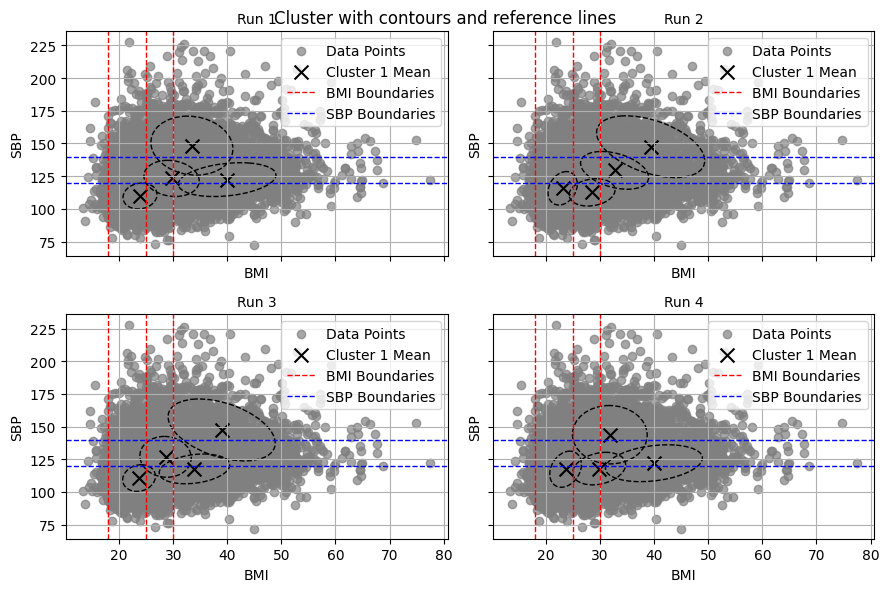

In [46]:
# Example usage in subplots with 2 graphs per row
cols = 2  # Number of columns in the subplot grid
rows = (num_runs + cols - 1) // cols  # Calculate the required number of rows
fig, axes = plt.subplots(rows, cols, figsize=(9, 3 * rows), sharex=True, sharey=True)

if rows == 1:
    axes = [axes]  # Ensure axes is always a list
axes = np.array(axes).flatten()  # Flatten axes array for easier indexing

bmi_bounds = np.array([18, 25, 30, np.inf])
sbp_bounds = np.array([120, 140, np.inf])

for run, (ax, run_samples) in enumerate(zip(axes, all_run_samples)):
    mu_samples = np.array([s[1] for s in run_samples])  # Means
    sigma_samples = np.array([s[2] for s in run_samples])  # Covariances

    plot_with_reference_lines(mu_samples, sigma_samples, bmi_bounds, sbp_bounds, ax)
    ax.set_title(f"Run {run + 1}", fontsize=10)

plt.tight_layout()
plt.suptitle("Cluster with contours and reference lines")
plt.show()